In [34]:
import pandas as pd
import numpy as np
import os
import math
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_excel("initial_data/nipt_data.xlsx")
print(df.head())

   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1   
1   2  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230531       2   
2   3  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230625       3   
3   4  A001  31  160.0  74.0  2023-02-01 00:00:00  自然受孕  20230716       4   
4   5  A002  32  149.0  74.0  2023-11-09 00:00:00  自然受孕  20240219       1   

    检测孕周  ...    Y染色体浓度    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  \
0  11w+6  ...  0.025936  0.038061     0.377069     0.389803     0.399399   
1  15w+6  ...  0.034887  0.059572     0.371542     0.384771     0.391706   
2  20w+1  ...  0.066171  0.075995     0.377449     0.390582     0.399480   
3  22w+6  ...  0.061192  0.052305     0.375613     0.389251     0.397212   
4  13w+6  ...  0.059230  0.059708     0.380260     0.393618     0.404868   

   被过滤掉读段数的比例  染色体的非整倍体  怀孕次数  生产次数  胎儿是否健康  
0    0.027484       NaN     1     

In [35]:
BMI_info=df['孕妇BMI']
Y_info=df['Y染色体浓度']

def convert_ga_to_decimal(ga_str):
    """将“Xw+Y”格式转换为小数周（如11w+6 = 11 + 6/7 ≈ 11.86周）"""
    if pd.isna(ga_str):
        return np.nan
    if 'w+' in str(ga_str):
        w_part, d_part = str(ga_str).split('w+')
    else:
        return np.nan
    try:
        return int(w_part) + int(d_part) / 7
    except (ValueError, IndexError):
        return np.nan
    

df['小数孕周'] = df['检测孕周'].apply(convert_ga_to_decimal)
df = df[(df['小数孕周'] >= 10) & (df['小数孕周'] <= 25)]

gestational_weeks_info=df['小数孕周']

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


model = smf.mixedlm(
    "Y染色体浓度 ~ 孕妇BMI + 小数孕周",
    df,
    groups=df["孕妇代码"] # 假设“孕妇ID”是唯一标识每个孕妇的列
)
# 拟合模型
result = model.fit()
# 打印结果汇总
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y染色体浓度   
No. Observations: 940     Method:             REML     
No. Groups:       260     Scale:              0.0003   
Min. group size:  1       Log-Likelihood:     2179.2491
Max. group size:  8       Converged:          Yes      
Mean group size:  3.6                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.065    0.018  3.700 0.000  0.031  0.100
孕妇BMI        -0.001    0.001 -2.159 0.031 -0.002 -0.000
小数孕周          0.003    0.000 17.009 0.000  0.003  0.003
Group Var     0.001    0.006                           



c:\Users\xia\anaconda3\envs\MCM\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


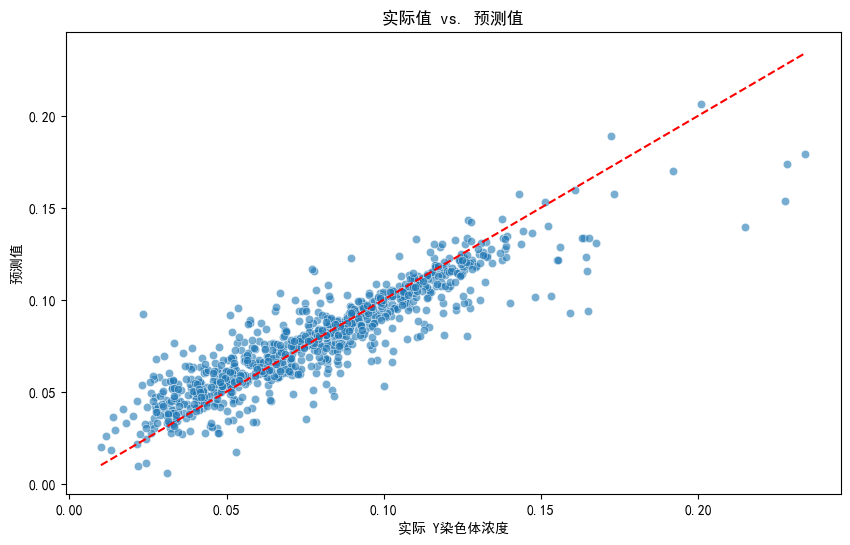

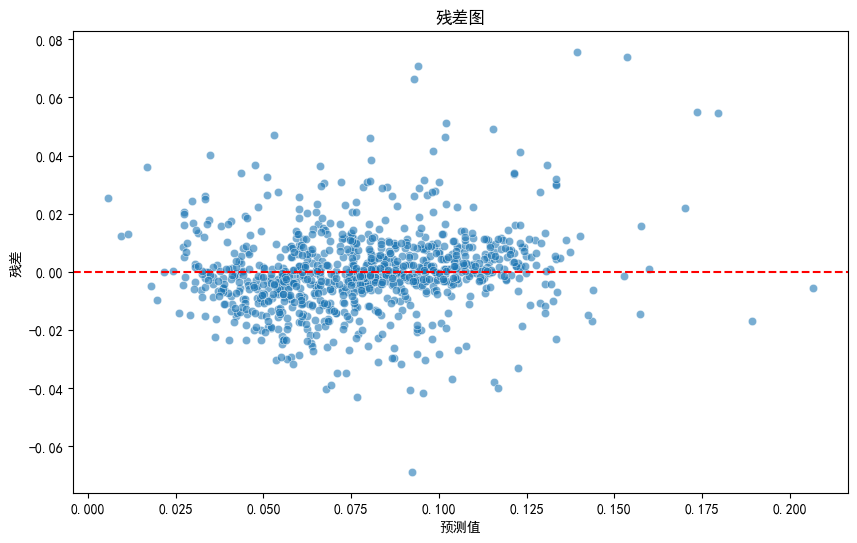

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df["预测值"] = result.fittedvalues
df["残差"] = df["Y染色体浓度"] - df["预测值"]  # 残差 = 实际值 - 预测值

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Y染色体浓度", y="预测值", alpha=0.6)
plt.plot([df["Y染色体浓度"].min(), df["Y染色体浓度"].max()],
         [df["Y染色体浓度"].min(), df["Y染色体浓度"].max()],
         'r--')  # 45度对角线
plt.title("实际值 vs. 预测值")
plt.xlabel("实际 Y染色体浓度")
plt.ylabel("预测值")
plt.show()

# 可视化 2：残差图(图)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="预测值", y="残差", alpha=0.6)
plt.axhline(0, color='r', linestyle='--')  # 中心线
plt.title("残差图")
plt.xlabel("预测值")
plt.ylabel("残差")
plt.show()


C:\Users\xia\AppData\Local\Temp\ipykernel_32540\3172958820.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept, coef_bmi, coef_weeks = params[0], params[1], params[2]


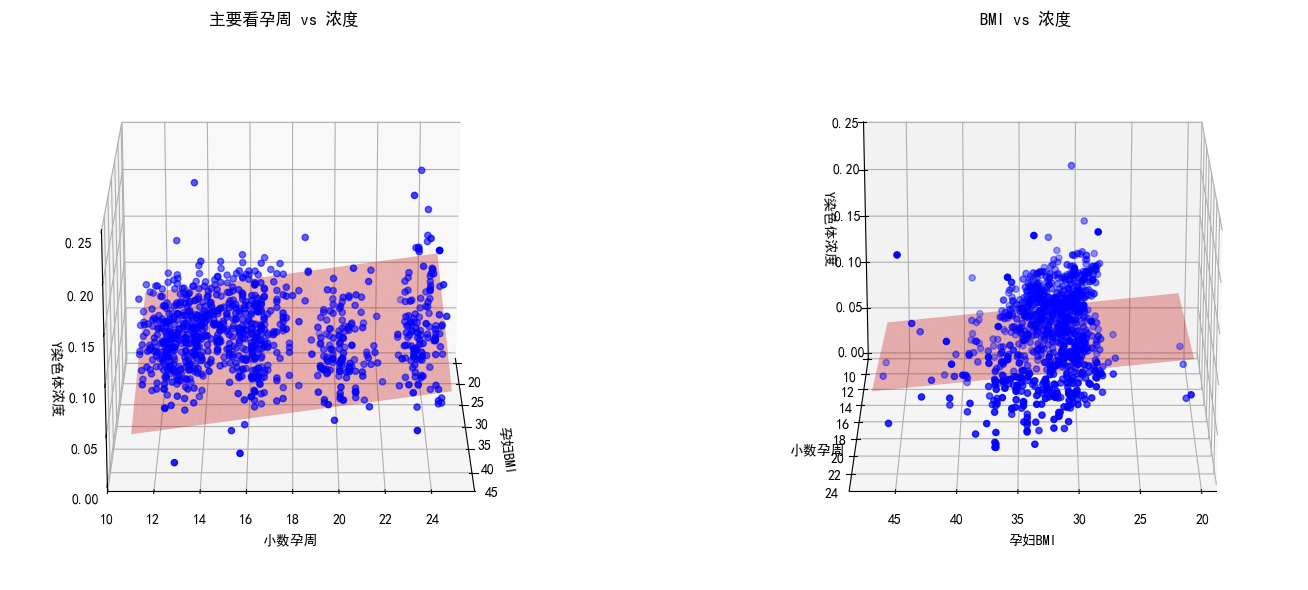

In [ ]:
# 生成预测网格
bmi_grid, weeks_grid = np.meshgrid(
    np.linspace(df["孕妇BMI"].min(), df["孕妇BMI"].max(), 50),
    np.linspace(df["小数孕周"].min(), df["小数孕周"].max(), 50)
)
params = result.params
intercept, coef_bmi, coef_weeks = params[0], params[1], params[2]
y_grid = intercept + coef_bmi * bmi_grid + coef_weeks * weeks_grid
fig = plt.figure(figsize=(16, 6))

# --- 视角1 ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(df["孕妇BMI"], df["小数孕周"], df["Y染色体浓度"], c='b', marker='o', label='实际值')
ax1.plot_surface(bmi_grid, weeks_grid, y_grid, alpha=0.3, color='r')
ax1.set_xlabel('孕妇BMI')
ax1.set_ylabel('小数孕周')
ax1.set_zlabel('Y染色体浓度')
ax1.set_title('主要看孕周 vs 浓度')
ax1.view_init(elev=20, azim=0)

# --- 视角2 ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(df["孕妇BMI"], df["小数孕周"], df["Y染色体浓度"], c='b', marker='o', label='实际值')
ax2.plot_surface(bmi_grid, weeks_grid, y_grid, alpha=0.3, color='r')
ax2.set_xlabel('孕妇BMI')
ax2.set_ylabel('小数孕周')
ax2.set_zlabel('Y染色体浓度')
ax2.set_title('BMI vs 浓度')
ax2.view_init(elev=20, azim=90)

plt.tight_layout()
plt.show()
